In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath('../home/stefggl/.local/lib/python3.8/site-packages'))
sys.path.insert(0, '/content/')
print(sys.path)

['/content/', '/content', '/home/stefggl/.local/lib/python3.8/site-packages', '/env/python', '/usr/lib/python39.zip', '/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '', '/usr/local/lib/python3.9/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.9/dist-packages/IPython/extensions', '/root/.ipython']


In [2]:
!pip install emnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!git clone https://github.com/aimacode/aima-python.git
!pip install -r /content/aima-python/requirements.txt
%cd aima-python/
!git submodule init
!git submodule update
!pip install pytest

Cloning into 'aima-python'...
remote: Enumerating objects: 5095, done.
remote: Total 5095 (delta 0), reused 0 (delta 0), pack-reused 5095
Receiving objects: 100% (5095/5095), 17.44 MiB | 28.03 MiB/s, done.
Resolving deltas: 100% (3418/3418), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.3/468.3 kB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 11.4 MB/s eta 0:00:00
  Created wheel for image: filename=image-1.5.33-p

In [4]:
!rm /content/aima-python/utils.py
!mv /content/utils.py /content/aima-python/
%cd /content/

/content


In [5]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=1.0):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true,});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


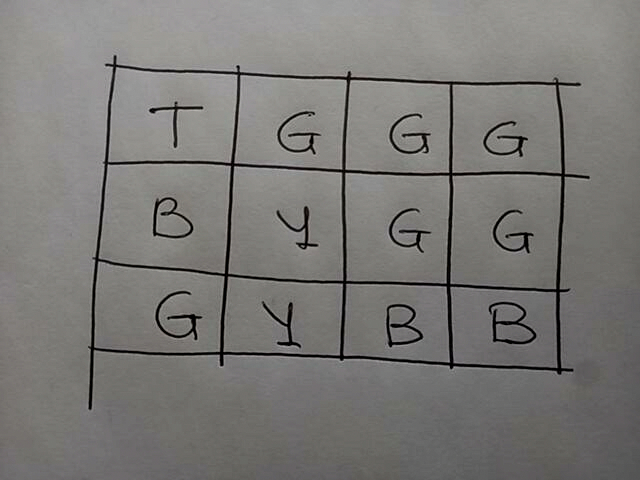

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [6]:
import sys
import numpy
import cv2 as cv
from PIL import Image, ImageOps, ImageDraw
from scipy import ndimage
from google.colab.patches import cv2_imshow # for image display
import matplotlib.pyplot as plt


def boxes(orig):
    img = ImageOps.grayscale(orig)
    im = numpy.array(img)

    # External gradient
    im = ndimage.morphological_gradient(im, (5, 5))
    cv2_imshow(im)

    # Binarize
    mean, std = im.mean(), im.std()
    t = mean + std
    im[im < t] = 0
    im[im >= t] = 1

    # Connected components
    lbl, numcc = ndimage.label(im)

    # Size threshold
    min_size = 200 # pixels adjust manually
    box = [] # array box

    for i in range(1, numcc + 1):
        py, px = numpy.nonzero(lbl == i)
        if len(py) < min_size:
            im[lbl == i] = 0
            continue

        xmin, xmax, ymin, ymax = px.min(), px.max(), py.min(), py.max()

        # Four corners and centroid.
        box.append([
            [(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)],
            (numpy.mean(px), numpy.mean(py))])
   
    return im.astype(numpy.uint8) * 255, box

In [7]:
def find_table_index(box):
  areamindex = -1
  aream = 0
  for x in range(len(box)):
    w = box[x][0][1][0] - box[x][0][0][0]
    h = box[x][0][2][1] - box[x][0][0][1]

    area = w * h

    if ( aream < area):
      aream = area
      areamindex = x
  
  return areamindex

In [10]:
def printimg(filename, box):
  
  img = cv.imread("photo.jpg")

  xmin = box[0][0][0]
  ymin = box[0][0][1]
  xmax = box[0][2][0]
  ymax = box[0][2][1]

  w = xmax - xmin
  h = ymax - ymin

  #image cropped have a margin of 7.5 % becouse the box results a little bit restrictive for the letters
  cropped_image = img[ int(ymin - h*0.075) : int(ymax + h*0.075) , int(xmin - w*0.075) : int(xmax + w*0.075)] 
  
  # Convert to grayscale    
  gray = cv.cvtColor(cropped_image, cv.COLOR_BGR2GRAY) 

  # Blur the image 
  blur = cv.GaussianBlur(gray, (5, 5), 0)

  th_GAUSSIAN = cv.adaptiveThreshold(blur,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,2)
      
  #resize image
  resize = cv.resize(th_GAUSSIAN, (28, 28), interpolation = cv.INTER_CUBIC)

  #show and save
  cv2_imshow(resize)
  cv.imwrite(filename, resize)

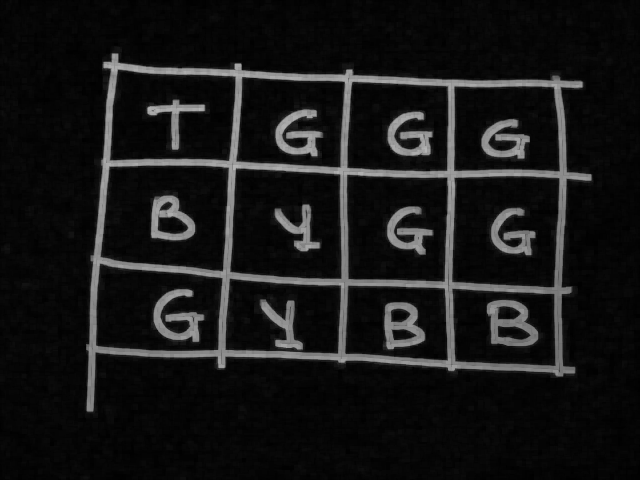

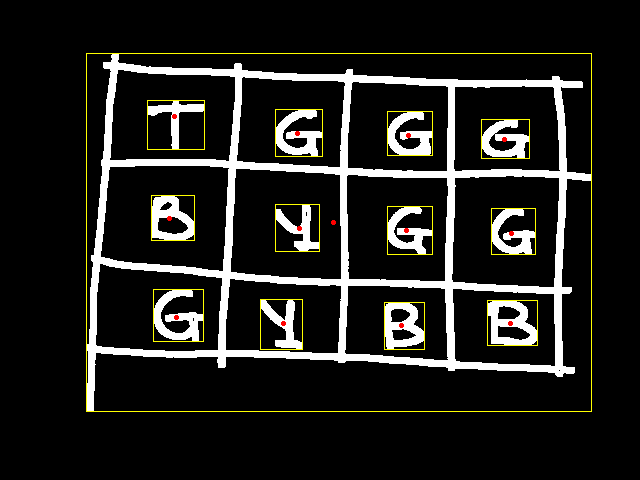

FIRST RAW: y min: 100 y max: 149
Primo elemento inserito

ACTIVE #0 RAW: y min: 100 y max: 149
BOX: y_center: 132.5
Elemento inserito in riga 0

ACTIVE #0 RAW: y min: 100 y max: 156
BOX: y_center: 133.0
Elemento inserito in riga 0

ACTIVE #0 RAW: y min: 100 y max: 156
BOX: y_center: 138.5
Elemento inserito in riga 0

ACTIVE #0 RAW: y min: 100 y max: 158
BOX: y_center: 217.5
Nuova riga creata e elemento inserito in riga 1

ACTIVE #1 RAW: y min: 195 y max: 240
BOX: y_center: 227.5
Elemento inserito in riga 1

ACTIVE #1 RAW: y min: 195 y max: 251
BOX: y_center: 230.0
Elemento inserito in riga 1

ACTIVE #1 RAW: y min: 195 y max: 254
BOX: y_center: 231.0
Elemento inserito in riga 1

ACTIVE #1 RAW: y min: 195 y max: 254
BOX: y_center: 315.0
Nuova riga creata e elemento inserito in riga 2

ACTIVE #2 RAW: y min: 289 y max: 341
BOX: y_center: 322.5
Elemento inserito in riga 2

ACTIVE #2 RAW: y min: 289 y max: 345
BOX: y_center: 324.0
Elemento inserito in riga 2

ACTIVE #2 RAW: y min: 289 y max:

01.jpg
[[(275, 109), (322, 109), (322, 156), (275, 156)], (297.6184560780834, 133.91481810115351)]


02.jpg
[[(387, 111), (432, 111), (432, 155), (387, 155)], (408.88295880149815, 135.71722846441946)]


03.jpg
[[(481, 119), (529, 119), (529, 158), (481, 158)], (504.43320235756386, 139.80550098231828)]


10.jpg
[[(151, 195), (194, 195), (194, 240), (151, 240)], (169.49226569608734, 218.50409463148316)]


11.jpg
[[(275, 204), (319, 204), (319, 251), (275, 251)], (299.0248447204969, 228.30062111801243)]


12.jpg
[[(387, 206), (432, 206), (432, 254), (387, 254)], (406.903, 230.809)]


13.jpg
[[(491, 208), (535, 208), (535, 254), (491, 254)], (511.17395626242546, 233.58349900596423)]


20.jpg
[[(153, 289), (203, 289), (203, 341), (153, 341)], (176.59735973597358, 317.0676567656766)]


21.jpg
[[(260, 299), (302, 299), (302, 349), (260, 349)], (283.22115384615387, 323.8942307692308)]


22.jpg
[[(384, 302), (424, 302), (424, 349), (384, 349)], (401.8438331854481, 325.6468500443656)]


23.jpg
[[(487, 300), (537, 300), (537, 345), (487, 345)], (510.28826728826726, 323.3162393162393)]


In [11]:
orig = Image.open("photo.jpg")
im, box = boxes(orig)

# Draw perfect rectangles and the component centroid.
img = Image.fromarray(im)
visual = img.convert('RGB')
draw = ImageDraw.Draw(visual)
for b, centroid in box:
    draw.line(b + [b[0]], fill='yellow')
    cx, cy = centroid
    draw.ellipse((cx - 2, cy - 2, cx + 2, cy + 2), fill='red')
visual.show()

#remove table cell
box.pop(find_table_index(box))

#order by y center coordinate
box.sort(key= lambda x: x[1][1])

#define a matrix
table = [[]] 
row = 0
y_row_min = 0
y_row_max = 0

table[row].append(box[0])
y_row_min = box[0][0][0][1]
y_row_max = box[0][0][2][1]

print("FIRST RAW: y min: "+str(y_row_min)+" y max: "+str(y_row_max) + "\nPrimo elemento inserito\n")

for x in box[1:]:

  print("ACTIVE #"+str(row)+" RAW: y min: "+str(y_row_min)+" y max: "+str(y_row_max))
  print("BOX: y_center: "+str((x[0][0][1]+x[0][2][1])/2))

  if ( y_row_min*0.9 < (x[0][0][1]+x[0][2][1])/2 < y_row_max*1.1):
    table[row].append(x)
    if(y_row_min > x[0][0][1]):
      y_row_min = x[0][0][1]
    if(y_row_max < x[0][2][1]):
      y_row_max = x[0][2][1]

    print("Elemento inserito in riga "+str(row)+"\n")

  else:
    table.append([])
    row = row + 1 
    table[row].append(x)
    y_row_min = x[0][0][1]
    y_row_max = x[0][2][1]

    print("Nuova riga creata e elemento inserito in riga "+str(row)+"\n")

#sort for x coordinate (sort one raw at time)
for x in table:
  x.sort(key= lambda x: x[1][0])

w=len(table)
h=len(table[0])

print("La tabella è di dimensione: "+str(w)+"x"+str(h)+"\n")

#save image
final_arr=[]
for row in range(len(table)):
  for col in range(len(table[row])):
    filename = str(row)+str(col)+".jpg"
    print(filename)
    print(table[row][col])
    printimg(filename, table[row][col])
    final_arr.append(cv.imread(filename))


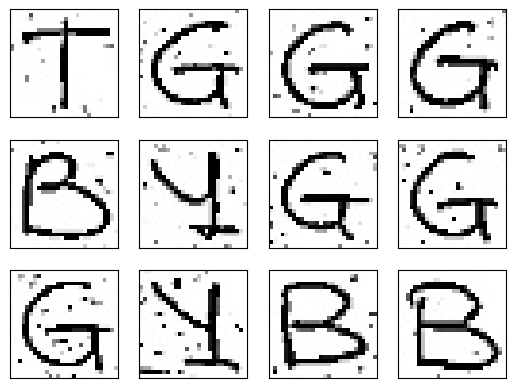

In [12]:
#final print
for i in range(len(box)):
  plt.subplot(w,h,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(final_arr[i])
  #plt.xlabel(class_names[label])
plt.show()

In [13]:
#move photo to dir
![ -f "photo.jpg" ] && rm "photo.jpg"
![ -d "output" ] && rm -r output
!mkdir output/
![ -f *.jpg ] && mv *.jpg output/
!mv *.jpg output/

/bin/bash: line 0: [: too many arguments


In [14]:
#Load up EMNIST database and local one
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from emnist import list_datasets
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

In [15]:
from emnist import extract_training_samples
emnist_images, emnist_labels = extract_training_samples('letters')

In [16]:
bgty=[2,7,20,25]
bgty_indices=[]
lookup = { '2':1, '7':3, '20':0, '25':2 }

for i in range(len(emnist_labels)):
  if emnist_labels[i] in bgty:
    bgty_indices.append(i)

bgty_images_i=[]
bgty_labels_i=[]

for p in range(len(bgty_indices)):
  bgty_images_i.append(emnist_images[bgty_indices[p]])
  bgty_labels_i.append(lookup[str(emnist_labels[bgty_indices[p]])])

In [17]:
#Unzip the local folder
!unzip a_set_of_fonts.zip
!mkdir digital_data && mv *.png digital_data

Streaming output truncated to the last 5000 lines.
  inflating: Y<Font: MaskedMarvelExpanded>.png  
  inflating: Y<Font: MaskedMarvelItalic>.png  
  inflating: Y<Font: MaskedMarvelLight>.png  
 extracting: Y<Font: MaskedMarvelRotate>.png  
 extracting: Y<Font: MassiveHeadache3>.png  
 extracting: Y<Font: MassiveHeadache>.png  
 extracting: Y<Font: Matt9>.png      
  inflating: Y<Font: Maximillion>.png  
 extracting: Y<Font: Mcgannahan>.png  
 extracting: Y<Font: MechEffects1BB-Italic>.png  
  inflating: Y<Font: MechEffects1BB>.png  
 extracting: Y<Font: MechEffects2BB-Italic>.png  
  inflating: Y<Font: MechEffects2BB>.png  
  inflating: Y<Font: Megalomaniax-KG>.png  
 extracting: Y<Font: Meltasstic>.png  
 extracting: Y<Font: MemeFont>.png   
 extracting: Y<Font: MfRusty>.png    
 extracting: Y<Font: MightyZeo20>.png  
 extracting: Y<Font: MightyZeo20Bold>.png  
 extracting: Y<Font: MightyZeo20Italic>.png  
 extracting: Y<Font: MightyZeo>.png  
 extracting: Y<Font: MightyZeoBold>.png  

In [18]:
#lists all filenames onto a file
!cd digital_data/ && ls > all_fonts.txt && ls | grep "all_fonts" | cat all_fonts.txt | less

all_fonts.txt
b<Font: 08Underground>.png
b<Font: 20CENTSMARKER-Bold>.png
B<Font: 20CENTSMARKER-Bold>.png
b<Font: 28DaysLater>.png
B<Font: 28DaysLater>.png
b<Font: 50'sHeadlineDSG>.png
B<Font: 50'sHeadlineDSG>.png
b<Font: 5cent>.png
b<Font: 98BottlesofBeerBoldCondensedItalic>.png
b<Font: 98BottlesofBeerBoldCondensed>.png
b<Font: 98BottlesofBeerBold>.png
b<Font: 98BottlesofBeerCondensed>.png
b<Font: 98BottlesofBeer>.png
b<Font: Aamunkoi>.png
B<Font: Aamunkoi>.png
b<Font: AbcTeacher>.png
B<Font: AbcTeacher>.png
b<Font: Abe>.png
B<Font: Abe>.png
b<Font: AbigailsHand-Plain>.png
B<Font: AbigailsHand-Plain>.png
b<Font: AbstractClassicFont>.png
>8

In [19]:
import cv2 as cv
from google.colab.patches import cv2_imshow

#Read the lists of names to open corresponding images and save corresponding labels
#onto the corresponding array

path = sys.path[0]+"/digital_data/" #[0-22]

names = { 'T':0, 't':0, 'B':1, 'b':1, 'G':3, 'g':3, 'Y':2, 'y':2 }

local_images=[]
local_labels=[]

with open(path+"all_fonts.txt") as file:
  for line in file.readlines():
    filename = line.rstrip()
    if (filename != 'all_fonts.txt'):
      imaget= cv.imread(path+filename, flags = cv.IMREAD_GRAYSCALE)
      imaget = cv.bitwise_not(imaget)
      local_images.append(imaget)
      local_labels.append(names[filename[:1]])

In [20]:
#Append the two arrays together to get the final dataset
images = np.concatenate((np.array(bgty_images_i), np.array(local_images)))

labels= np.array(bgty_labels_i + local_labels)

In [21]:
#Normalizing values
images= images.astype("float32")/255

In [22]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=100)
print("Training images")
print(type(X_train))
print(X_train.shape)
print("Training labels")
print(type(y_train))
print(y_train.shape)
print("Testing images")
print(type(X_val))
print(X_val.shape)
print("Testing labels")
print(type(y_val))
print(y_val.shape)

Training images
<class 'numpy.ndarray'>
(19782, 28, 28)
Training labels
<class 'numpy.ndarray'>
(19782,)
Testing images
<class 'numpy.ndarray'>
(8479, 28, 28)
Testing labels
<class 'numpy.ndarray'>
(8479,)


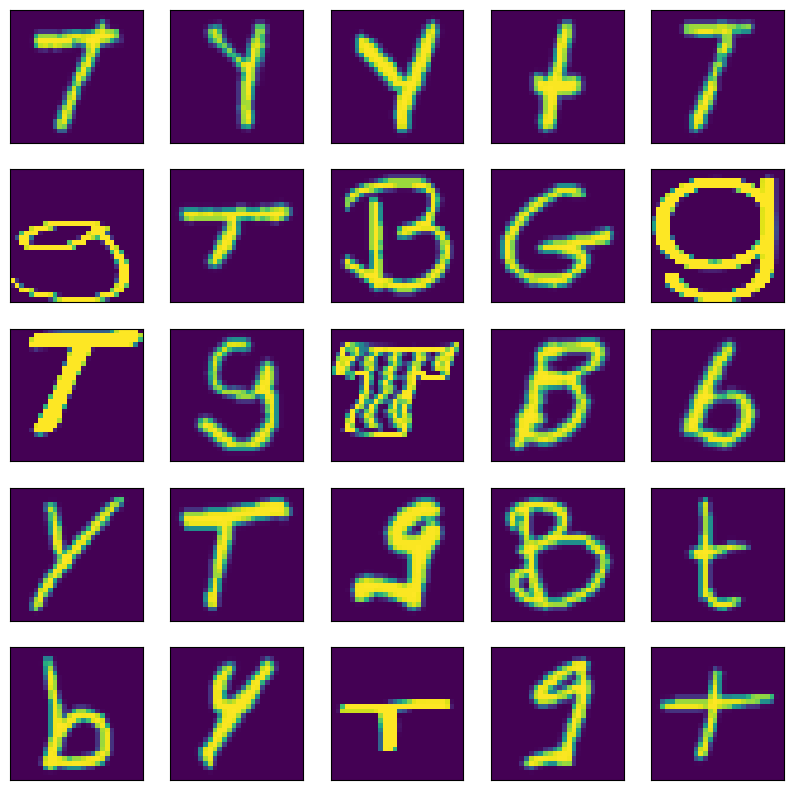

In [23]:
from random import randint
import matplotlib.pyplot as plt

t= randint(0,19781)

plt.figure(figsize=(10,10))
for i,image in enumerate(X_train[t:t+25]):
    #image = imge.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    #plt.xlabel(class_names[label])
plt.show()

In [24]:
f_v_l= 784
X_train = X_train.reshape(X_train.shape[0], f_v_l)
X_val = X_val.reshape(X_val.shape[0], f_v_l)
print(X_train.shape)
print(X_val.shape)

(19782, 784)
(8479, 784)


In [25]:
bgty_model = keras.Sequential()

bgty_model.add(layers.Dropout(
                        0.5,
                        input_shape = (f_v_l,)
))
bgty_model.add(layers.Dense(
                        1024,
                        kernel_initializer = "lecun_normal",
                        activation = "selu"
))
bgty_model.add(layers.Dense(
                        2048,
                        activation = "relu"
))
bgty_model.add(layers.Dense(
                        1024,
                        activation = "relu"
))
bgty_model.add(layers.Dense(
                        4,
                        activation = "softmax"
))

bgty_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 1024)              803840    
                                                                 
 dense_1 (Dense)             (None, 2048)              2099200   
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_3 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 5,005,316
Trainable params: 5,005,316
Non-trainable params: 0
_________________________________________________________________


In [26]:
#Training and Evaluation

batch_size = 256
epochs = 10

bgty_model.compile(loss="sparse_categorical_crossentropy",
                  optimizer = "adam",
                  metrics = ["accuracy"])
history = bgty_model.fit(X_train, y_train, batch_size = 256, epochs=epochs,
                         validation_data=(X_val, y_val))

Epoch 1/10
78/78 [==============================] - 21s 260ms/step - loss: 0.5683 - accuracy: 0.7943 - val_loss: 0.2441 - val_accuracy: 0.9097
Epoch 2/10
78/78 [==============================] - 20s 263ms/step - loss: 0.2777 - accuracy: 0.8984 - val_loss: 0.1971 - val_accuracy: 0.9284
Epoch 3/10
78/78 [==============================] - 19s 248ms/step - loss: 0.2132 - accuracy: 0.9226 - val_loss: 0.1622 - val_accuracy: 0.9433
Epoch 4/10
78/78 [==============================] - 21s 263ms/step - loss: 0.1896 - accuracy: 0.9338 - val_loss: 0.1359 - val_accuracy: 0.9516
Epoch 5/10
78/78 [==============================] - 18s 227ms/step - loss: 0.1754 - accuracy: 0.9388 - val_loss: 0.1395 - val_accuracy: 0.9500
Epoch 6/10
78/78 [==============================] - 19s 240ms/step - loss: 0.1458 - accuracy: 0.9473 - val_loss: 0.1247 - val_accuracy: 0.9574
Epoch 7/10
78/78 [==============================] - 19s 240ms/step - loss: 0.1360 - accuracy: 0.9519 - val_loss: 0.1223 - val_accuracy: 0.9599

In [27]:
score= bgty_model.evaluate(X_val, y_val, verbose=0)

print(f"Test loss: {score[0]}\nTest Accuracy: {score[1]}")

Test loss: 0.1269599199295044
Test Accuracy: 0.9554192423820496


In [28]:
!mkdir fonts/
!mv *Font*png fonts/

mv: cannot stat '*Font*png': No such file or directory


1/1 [==============================] - 0s 109ms/step
[[3.7114648e-04 9.8984909e-01 5.6130208e-05 9.7236587e-03]]
1.0
la predizione è: 1
(28, 28)


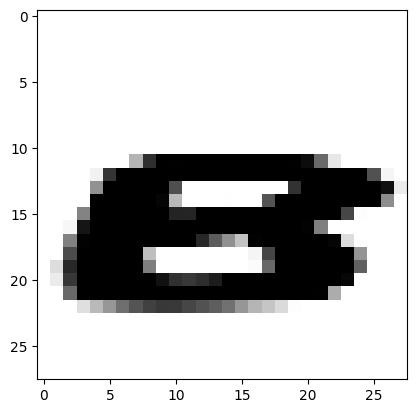

In [29]:
#Single test
import matplotlib.pyplot as plt
import random as rand

one_case=rand.randrange(0,len(X_val))

predictions_single = bgty_model.predict(X_val[one_case:(one_case + 1)])
print(predictions_single)
print(np.sum(predictions_single))
#print(X_test[one_case:(one_case + 1)])



y_classes = predictions_single.argmax()
print("la predizione è: {}".format(y_classes))

x_test_vis = X_val[one_case:(one_case+1)].reshape(28, 28)
print(x_test_vis.shape)
plt.imshow(x_test_vis, cmap = plt.cm.binary)

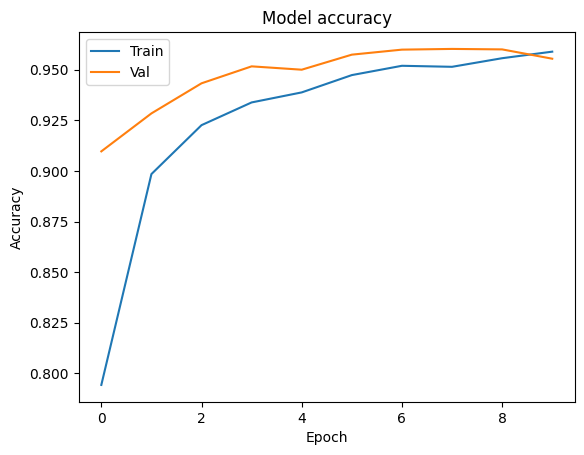

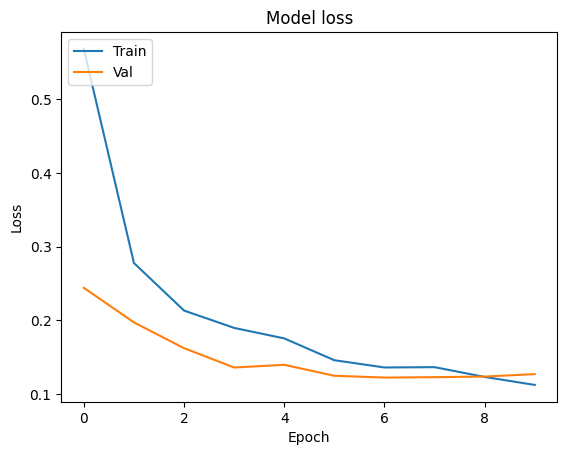

In [30]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [31]:
#max_prob=0.05
#map_prob=1.00

def close_enough_linear(prob_array, labels):
  prob_array=np.asarray(prob_array)

  #= (X, 1, 4)
  if (prob_array.ndim == 3 and prob_array[0].shape == (1, 4)):
    #
    index,tmp = -1,0
    for i in range(len(labels)):
      #if (labels[i] == 0 or labels[i] == 3): #T or Y
      if (prob_array[i][0][0] > tmp):
        tmp = prob_array[i][0][0] #T
        index = i
    if (index != -1):
      print(f"Likeliest candidate is at index {index} with probability {tmp}")
      return index
    else:
      raise Exception("No Likely T was found in the data")
  else:
    raise Exception("Array of not (X, 1, 4) shape")
  #O(n) preciso
        
def ttt_out(array, trueish_t):
    #set the most likely image to be a t to the actual t's. All else to y
    array= np.asarray(array) #check for array to be of numpy.ndarray
    if (array.ndim == 1):
      for a in range(0,len(array)):
        if (a==trueish_t):
          array[a] = 0 #the most likely T
        else: 
          if (array[a] == 0): #if all other non-likely Ts
            array[a]=3 #Y
      return array
    else:
        raise Exception("Non 1-Dimensional array")

#Funzioni inizialmente scritte per scikit-learn, che supportavano la funzione predict_proba,
#che riportava array di probabilità, la quale non è presente su keras. ne creo una manuale

def get_prob_array(model, data):
  prob_array=[]
  prov_array=[]
  for one_case in range(0,len(data)):
    predictions_single = model.predict(data[one_case:(one_case + 1)])
    prob_array.append(predictions_single)
    prov_array.append(predictions_single.argmax())
  return prob_array, prov_array
        
#Impacchetto le due funzioni in un'unica chiamata
#Questa funzione prenderà in input il solo array delle Y e T
    
def cleandata(data, probabilities, labels):
    return ttt_out(data, close_enough_linear(probabilities, labels))

In [32]:
import cv2 as cv
from google.colab.patches import cv2_imshow

#carico le celle della griglia sul modello

dir=sys.path[0]
path="/output/"
i,width,height=0,0,0
data=[]

!cd output/ && ls > path1

#import image in dir
with open((dir + path + "path1")) as file:
  for line in file.readlines():
    keyword=line.rstrip()
    if (keyword != "path1" and
        keyword != "file.jpg" and
        keyword != "finalimg.jpg" and
        keyword != "photo.jpg"):
      i+=1
      filename=dir+path+keyword
      if(filename[(len(filename)-6):(len(filename)-4)] == "10"):
        #first row
        width = i-1
      print(filename)
      imaget = cv.imread(filename, flags= cv.IMREAD_GRAYSCALE)
      imaget = cv.bitwise_not(imaget)
      imaget= imaget.reshape(28,28)
      cv2_imshow(imaget)
        
      #Normalizzo le immagini
      #shape image as single array
      imaget=imaget.reshape(1, 784)
      imaget= imaget.astype("float32")/255
      data.append(imaget)

print(filename[(len(filename)- 6):(len(filename)- 4)])

height = i//width

print(f"width: {width}\nheight: {height:0.0f}")

/content//output/00.jpg


/content//output/01.jpg


/content//output/02.jpg


/content//output/03.jpg


/content//output/10.jpg


/content//output/11.jpg


/content//output/12.jpg


/content//output/13.jpg


/content//output/20.jpg


/content//output/21.jpg


/content//output/22.jpg


/content//output/23.jpg


23
width: 4
height: 3


In [33]:
probabilities, labels = get_prob_array(bgty_model, data)

for k in range(len(labels)):
  print(f"{probabilities[k]}")
print(np.asarray(probabilities).shape)
print(np.asarray(probabilities).ndim)
print(labels)
#passo le previsioni, dati e modello per ricavare il mio output
#finale

cleanup = cleandata(labels, probabilities, labels)

print(f"l'array finale è {cleanup}")

1/1 [==============================] - 0s 26ms/step
[[9.99958873e-01 1.78405880e-05 1.23859545e-05 1.08573431e-05]]
[[1.4484460e-05 4.5665438e-04 9.5797168e-06 9.9951935e-01]]
[[4.1372218e-06 6.2337617e-04 4.6782585e-05 9.9932575e-01]]
[[1.6024701e-06 1.1476117e-04 7.1452467e-07 9.9988294e-01]]
[[4.6474057e-08 9.9984467e-01 1.8553783e-08 1.5533523e-04]]
[[4.9694115e-03 3.6848721e-04 9.9201208e-01 2.6499922e-03]]
[[1.8063249e-05 8.1732910e-04 7.2386800e-05 9.9909222e-01]]
[[3.6756026e-07 4.5479732e-04 5.3676604e-06 9.9953949e-01]]
[[4.8579873e-06 2.4665839e-03 3.3808894e-05 9.9749482e-01]]
[[3.3947083e-03 7.2248984e-04 9.3712407e-01 5.8758724e-02]]
[[1.5175593e-05 9.9806708e-01 3.8798386e-05 1.8789392e-03]]
[[2.8989100e-09 9.9996829e-01 5.5094289e-09 3.1688116e-05]]
(12, 1, 4)
3
[0, 3, 3, 3, 1, 2, 3, 3, 3, 2, 1, 1]
Likeliest candidate is at index 0 with probability 0.999958872795105
l'array finale è [0 3 3 3 1 2 3 3 3 2 1 1]


In [34]:
cleanup = [cleanup[a] for a in range(0,len(cleanup))]
cleanup += [cleanup.index(0)]
cleanup

[0, 3, 3, 3, 1, 2, 3, 3, 3, 2, 1, 1, 0]

In [35]:
sys.path.insert(3, '/content/aima-python/')

In [103]:
#Breadth Depth Tree
#Breadth Depth Graph
#Best Graph
#Uniform Cost
#Depth Limited Search

from search import *
from collections import *

#ricerca in ampiezza, profondita' e costo
def breadth_search_graph(problem):
  node = Node(problem.initial)

  if problem.goal_test(node.state):
    return node

  frontier = deque([node])
  explored = set()

  while frontier:
    node = frontier.popleft()
    print(node)
    explored.add(tuple(node.state))
    for child in node.expand(problem):
      print(f"child state: {child.state}")
      print(f"Testina: {problem.get_t(child.state)}")
      if tuple(child.state) not in explored and child not in frontier: 
        if problem.goal_test(child.state):
          return child
        frontier.append(child)
  return None


def depth_search_graph(problem):
  node = Node(problem.initial)

  if problem.goal_test(node.state):
    return node

  frontier = deque([node])
  explored = set()

  while frontier:
    node = frontier.pop()
    print(node)
    explored.add(tuple(node.state))
    for child in node.expand(problem):
      print(f"child state: {child.state}")
      print(f"Testina: {problem.get_t(child.state)}")
      if tuple(child.state) not in explored and child not in frontier: 
        if problem.goal_test(child.state):
          return child
        frontier.append(child)
  return None

def depth_limited_search(problem, l):
  frontier= ([Node(problem.initial)])
  solution = 'failure'
  while frontier:
    node = frontier.pop()
    if problem.goal_test(node.state):
      solution = node
      return solution
    elif node.depth > l:
      solution = 'cutoff'
    elif not is_cycle(node):
      for child in node.expand(problem):
        print(f"child state: {child.state}")
        print(f"Testina: {problem.get_t(child.state)}")
        frontier.append(child)
  return solution

def is_cycle(node, k=5):
  """costa troppo controllare un ciclo di M lunghezza con M
  numero grande di passi. Imponiamo un limite k a 50"""
  def find_cycle(ancestor, k):
    """implementazione ricorsiva, altro pericolo"""
    return (ancestor is not None and k > 0
            and (ancestor.state == node.state or
            find_cycle(ancestor.parent, k-1)))
  return find_cycle(node.parent, k)

def interative_depending_search(problem):
    for limit in range(1, sys.maxsize):
        result = depth_limited_search(problem, limit)
        if result != 'cutoff':
            return result

def best_first_search_graph_h(problem, f, no_memoize = False, t = -1):
  init = Node(problem.initial)

  if problem.goal_test(init.state):
    return init
  
  f1 = f
  f2 = f

  f = memoize(f1, 'f')
  frontier = PriorityQueue('min', f)
  frontier.append(init)

  explored = set()

  #t = -1

  while frontier:
    node = frontier.pop()
    if ( t == 0 ) and problem.goal_cell(node.state):
        print("Trovata la soluzione!")
        return node
    explored.add(tuple(node.state))
    for child in node.expand(problem):
      if tuple(child.state) not in explored and child not in frontier: 
        if ( t == -1 ) and problem.goal_grid(child.state):
          t = 0
          f = memoize(f2, 'f')
          frontier = PriorityQueue('min', f)
          print("\n\n\n\n\n\n\nFound the solution! Coming back home\n\n\n\n\n\n")
          frontier.append(child)
          break
        frontier.append(child)
      elif child in frontier:
        incumbent = frontier.get_item(child)
        if f(incumbent) > f(child):
          del frontier[incumbent]
          frontier.append(child)
    print(f"heuristic: {f(node)}")
  return None

def unif_cost_search(problem):
  return best_first_search_graph_h(problem, lambda node: node.path_cost)

def show_solution(node):
  if node is None:
      print("no solution")
  else:
      print("solution: ", node.solution())

In [117]:
def a_star_search(problem, h = None):
  h = memoize(h or problem.h, 'h')
  return best_first_search_graph_h(problem, lambda n : h(n), no_memoize = False)

In [55]:
from search import *

#Definiamo il problema

#(self, initial, depth, height)
# Esempio
# stato = ( [1,0,3,3] , 2 )
# (stato, 2, 2)
# Nuova idea
# stato = ([1,0,3,3,2])
# (stato, 2, 2)

class UniformColor(Problem): 

  def __init__(self, initial, width, height):

    self.w = width
    self.height = height
    self.Tindex = len(initial)-1
    self.init_pos = initial[self.Tindex]

    self.one=[1 for a in range(width*height)] 
    self.one[self.init_pos]=0
    self.two=[2 for a in range(width*height)] 
    self.two[self.init_pos]=0
    self.three=[3 for a in range(width*height)] 
    self.three[self.init_pos]=0

    super().__init__(initial, goal=(self.one,self.two,self.three))

  def actions(self, state):
    cursor = state[self.Tindex]

    possible_actions = ['right', 'up', 'left', 'down', 'col-B', 'col-G', 'col-Y']

    
    if cursor % self.w == self.w - 1:
      possible_actions.remove('right')
    if cursor < self.w:
      possible_actions.remove('up')
    if cursor % self.w == 0:
      possible_actions.remove('left')
    if cursor >= self.w*(self.height - 1):
      possible_actions.remove('down')

    if state[0:len(state)-1] in self.goal:
      possible_actions.remove('col-B')
      possible_actions.remove('col-G')
      possible_actions.remove('col-Y')

    else:    
      if state[cursor] == 1:
        possible_actions.remove('col-B')
      if state[cursor] == 2:
        possible_actions.remove('col-Y')
      if state[cursor] == 3:
        possible_actions.remove('col-G')
      if state[cursor] == 0:
        possible_actions.remove('col-B')
        possible_actions.remove('col-G')
        possible_actions.remove('col-Y')

    return possible_actions

  def get_t(self, state):
    return state[self.Tindex]


  def result(self, state, action):

    print(action)

    #index of cursor
    cursor = state[self.Tindex]

    #transform tuple in list for coloring or switching position
    new_state = state[0:self.Tindex]
    
    if(action == 'col-B' or action == 'col-G' or action == 'col-Y'):

      coloring = {'col-B': 1, 'col-Y': 2, 'col-G': 3}

      new_state[cursor] = coloring[action]
    
    else:

      #dictionary to move and index
      moving = { 'right' : 1, 'up' : -self.w, 'left' : -1, 'down' : self.w }

      #index of T moved
      cursor += moving[action]

      #swap plate
      #new_state[cursor], new_state[neighbor] = new_state[neighbor], new_state[cursor]
      
    out_state = new_state + [cursor]
    return out_state

  #def goal_test(self, state):
  #  return state[0:self.Tindex] in self.goal and state[self.Tindex] == self.init_pos

  def goal_grid(self, state):
    return state[0:len(state)-1] in self.goal

  def goal_cell(self, state):
    return state[self.Tindex] == self.init_pos

  def path_cost(self, c, state1, action, state2):
    coloring = {'col-B': 1, 'col-Y': 2, 'col-G': 3}
    #costo unitario, sola distanza
    if action in coloring:
      paint_cost = coloring[action]
      return c + paint_cost
    else:
      return c + 1

In [178]:
def h(problem, node):
  return min(sum( s != g for (s,g) in zip(node.state, problem.one) ), sum( s!=g for (s,g) in zip(node.state, problem.two) ), sum( s!=g for (s,g) in zip(node.state, problem.three) ))

def hGrid(problem, node):
  return min([len(node.state) - node.state.count(k) - 1 for k in range(1,4)])

def hAll(problem, node):
  return min(
    sum([node.path_cost + 1 + 1  for a in range(0,len(node.state)-1) if node.state[a] != problem.one[a]]),
    sum([node.path_cost + 1 + 2  for a in range(0,len(node.state)-1) if node.state[a] != problem.two[a]]),
    sum([node.path_cost + 1 + 3  for a in range(0,len(node.state)-1) if node.state[a] != problem.three[a]])
)

In [153]:

# Imports for JupyterLite
%pip install -q ipywidgets

import cv2 
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
    
W, B, Y, G, W_T, B_T, Y_T, G_T = np.zeros((3,3,3), np.uint8), np.zeros((3,3,3), np.uint8), np.zeros((3,3,3), np.uint8), np.zeros((3,3,3), np.uint8), np.zeros((3,3,3), np.uint8), np.zeros((3,3,3), np.uint8), np.zeros((3,3,3), np.uint8), np.zeros((3,3,3), np.uint8)
W[::], B[::], Y[::], G[::], W_T[::], B_T[::], Y_T[::], G_T[::] = (255,255,255), (0,0,255), (255,255,0), (0,255,0), (255,255,255), (0,0,255), (255,255,0), (0,255,0)
W_T[1,1] = B_T[1,1] = Y_T[1,1] = G_T[1,1] = (255, 0, 0)

color = [W, B, Y, G, W_T , B_T, Y_T, G_T]

def visual(path_solution, move_solution, w, h):
  
  #path_solution is containo node, we extract the node.state
  state_solution = []

  for i in path_solution:
    state_solution.append(i.state)

  for state in range(len(state_solution)):

    #find index T
    T_index = state_solution[state][-1]

    #make index t colored us testina
    state_solution[state][T_index] = state_solution[state][T_index] + 4

    #remove index t in state
    state_solution[state] = state_solution[state][0:-1]

  #widget PART STARTING

  a = widgets.IntSlider(min=0,max=len(state_solution)-1,step=1,value=0,description='Step: ', continuous_update=True)
  ui = widgets.HBox([a])

  def f(a):

    for i in range(len(state_solution[a])):
      plt.subplot(h,w, i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(color[state_solution[a][i]])

    if(a==0):
      plt.suptitle(f"Stato iniziale, Prossima mossa: {move_solution[a]}")
    elif(a <= len(move_solution)-1):
      plt.suptitle(f"Mossa Applicata: {move_solution[a-1]} | Prossima mossa: {move_solution[a]}")
    else:
      plt.suptitle(f"Stato finale, Mossa Applicata: {move_solution[a-1]}")

    plt.show()

  out = widgets.interactive_output(f, {'a': a})
  display(ui, out)

In [182]:
array = [1,1,1,2,2,2,3,3,3,3,0,3,2,2,2,1,1,1]
array = array + [array.index(0)]
p2 = UniformColor(array, width = 3, height = 6)

In [187]:
p1 = UniformColor(cleanup, width, height)
p1

In [183]:
import time

In [ ]:
start_time = time.time()
solPuzzle = breadth_search_graph(p1)
end_time = time.time()

print_sol(solPuzzle.path(), solPuzzle.solution(), width, height)

print(solPuzzle)
print("\nBFS",show_solution(solPuzzle))
print('cost = ', solPuzzle.path_cost)
print('time = ', end_time-start_time)

In [ ]:
start_time = time.time()
solPuzzle = depth_search_graph(p1)
end_time = time.time()
print(solPuzzle)
print("\nBFS",show_solution(solPuzzle))
print('cost = ', solPuzzle.path_cost)
print('time = ', end_time-start_time)

In [ ]:
start_time = time.time()
solPuzzle = unif_cost_search(p1)
end_time = time.time()
print(solPuzzle)
print("\nBFS",show_solution(solPuzzle))
print('cost = ', solPuzzle.path_cost)
print('time = ', end_time-start_time)

In [ ]:
start_time = time.time()
solPuzzle = a_star_search(p2, lambda node : hGrid(p2, node))
#Euristica non pesata
end_time = time.time()

print_sol(solPuzzle.path(), solPuzzle.solution(), width, height)

print(solPuzzle)
print("\nBFS",show_solution(solPuzzle))
print('cost = ', solPuzzle.path_cost)
print('time = ', end_time-start_time)

right
down
heuristic: 16
right
left
down
col-B
col-Y
heuristic: 24
right
up
down
col-G
col-Y
heuristic: 24
right
left
down
col-G
col-Y
heuristic: 28
right
left
down
col-B
col-Y
heuristic: 30
right
up
left
down
col-B
col-G
heuristic: 30
right
up
col-B
col-Y
heuristic: 30
right
up
down
col-B
col-Y
heuristic: 32
right
down
heuristic: 35
right
left
down
col-B
col-Y
heuristic: 35
right
up
left
down
col-B
col-G
heuristic: 35
right
left
down
col-G
col-Y
heuristic: 35
right
up
left
down
col-G
col-Y
heuristic: 35
right
up
col-G
col-Y
heuristic: 35
left
down
col-B
col-Y
heuristic: 35
right
up
left
down
col-B
col-Y
heuristic: 35
right
up
left
col-B
col-G
heuristic: 35
right
up
down
col-B
col-G
heuristic: 35
right
left
down
col-G
col-Y
heuristic: 36
right
up
left
down
col-G
col-Y
heuristic: 36
right
up
left
down
col-B
col-Y
heuristic: 36
right
down
heuristic: 36
right
up
left
down
col-B
col-G
heuristic: 36
right
up
col-B
col-Y
heuristic: 36
right
up
left
down
col-B
col-Y
heuristic: 36
right
left
d

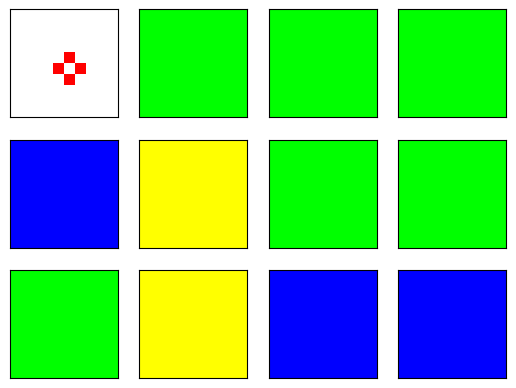





[0, 3, 3, 3, 1, 2, 3, 3, 3, 2, 1, 1, 4]


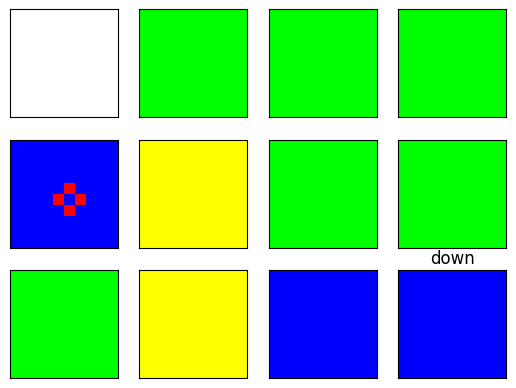





[0, 3, 3, 3, 3, 2, 3, 3, 3, 2, 1, 1, 4]


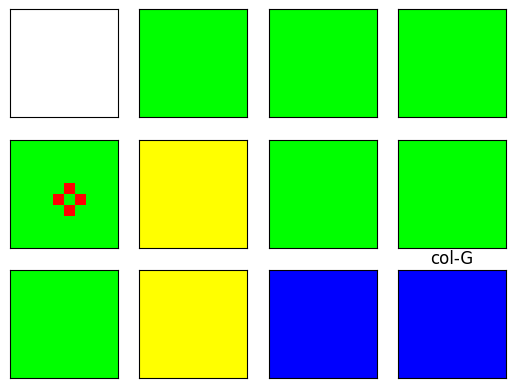





[0, 3, 3, 3, 3, 2, 3, 3, 3, 2, 1, 1, 5]


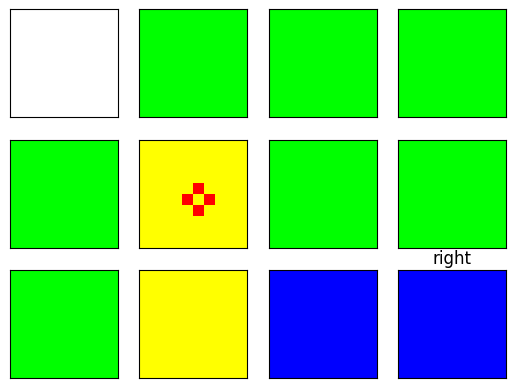





[0, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 5]


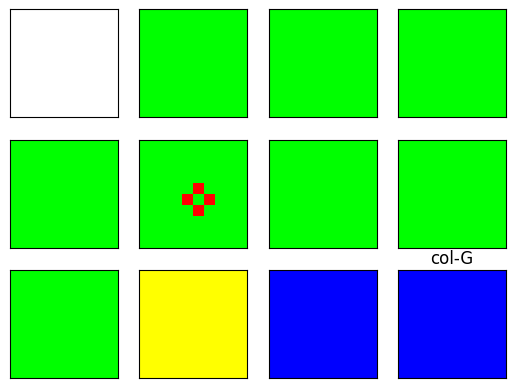





[0, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 9]


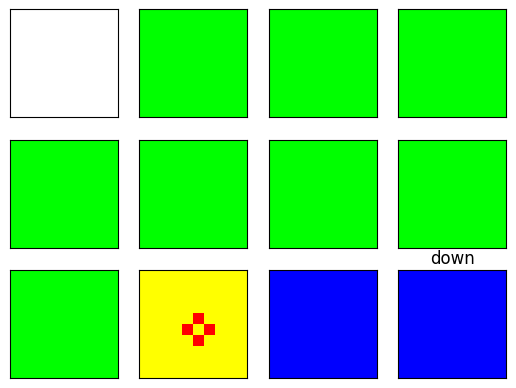





[0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 9]


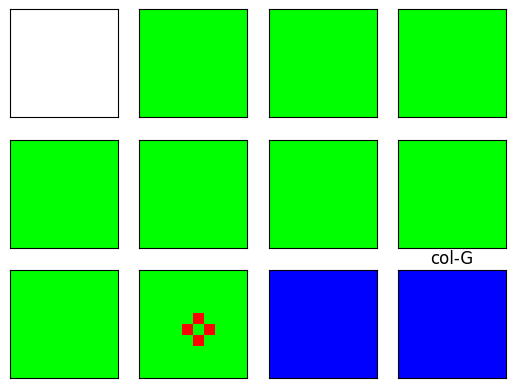





[0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 10]


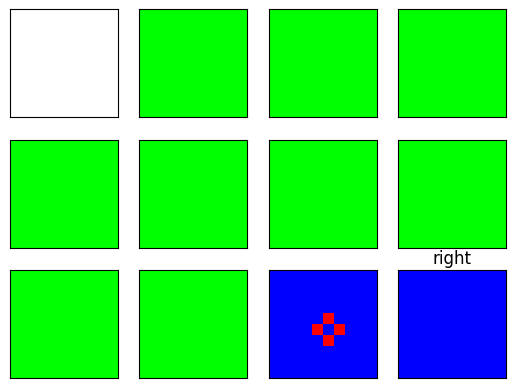





[0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 10]


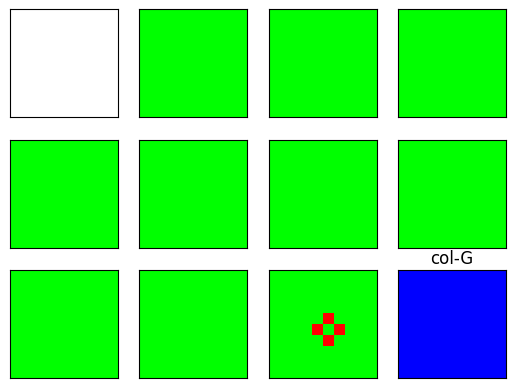





[0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 11]


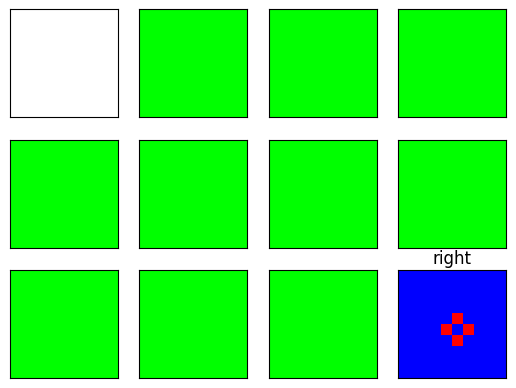





[0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 11]


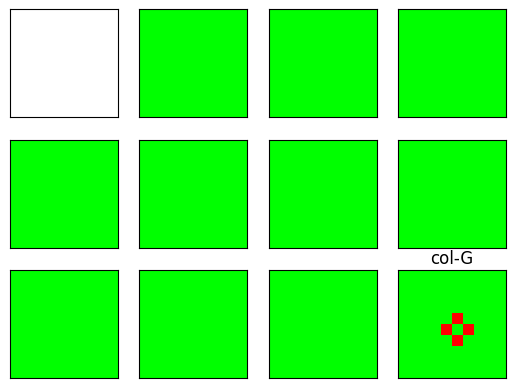





[0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7]


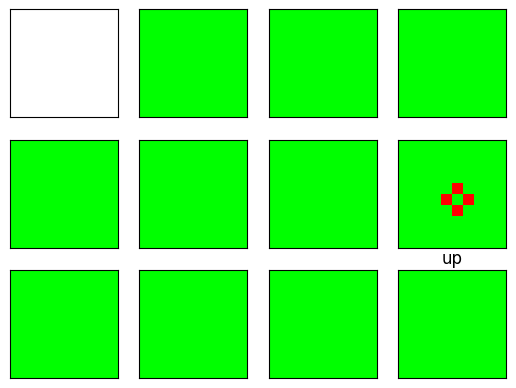





[0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


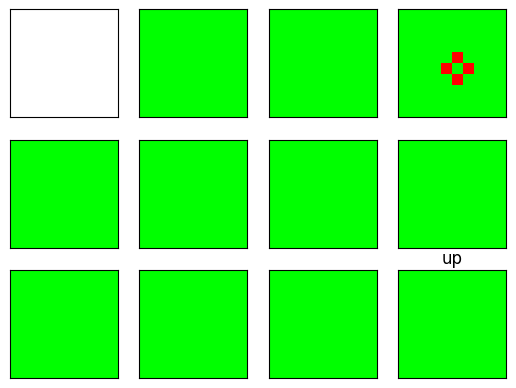





[0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2]


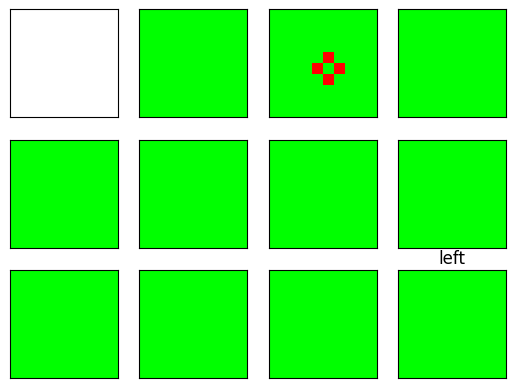





[0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1]


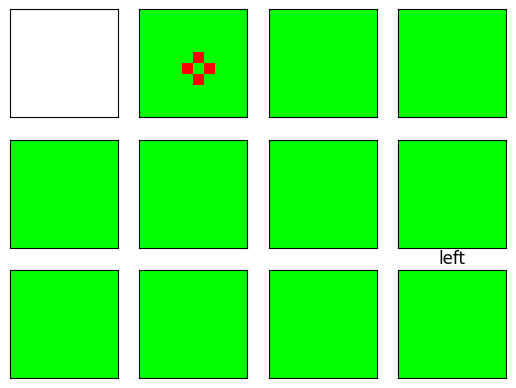





[0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0]


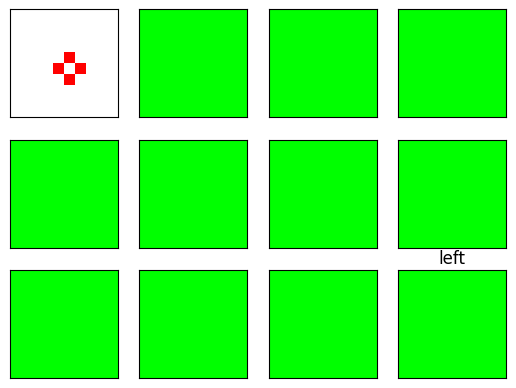





<Node [0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0]>
solution:  ['down', 'col-G', 'right', 'col-G', 'down', 'col-G', 'right', 'col-G', 'right', 'col-G', 'up', 'up', 'left', 'left', 'left']

BFS None
cost =  25
time =  0.05399918556213379


In [188]:
start_time = time.time()
solPuzzle = a_star_search(p1, lambda node : hAll(p1, node))
#Euristica pesata
end_time = time.time()

print_sol(solPuzzle.path(), solPuzzle.solution(), width, height)

print(solPuzzle)
print("\nBFS",show_solution(solPuzzle))
print('cost = ', solPuzzle.path_cost)
print('time = ', end_time-start_time)